In [5]:
import h5py
import pandas as pd
import numpy as np
from scipy import misc
import time
import sys
import matplotlib
from skimage import draw
import os
import matplotlib.pyplot as plt
import random
from glob import glob

In [6]:
fl = glob('/bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des/train/*.h5')

In [7]:
f = h5py.File(fl[0])

In [8]:
f.keys()

[u'HLF', u'Labels', u'Particles', u'Sources']

In [9]:
pf = f['Particles']

In [10]:
print pf.shape

(7500, 801, 18)


In [11]:
f['HLF']

<HDF5 dataset "HLF": shape (7500, 14), type "<f8">

In [12]:
f['Labels']

<HDF5 dataset "Labels": shape (7500, 3), type "<f8">

In [13]:
print f['Labels'][:5]

[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


In [14]:
features = ['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ','ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 
                        #'Charge'
           ]

In [15]:
colors = {'isMu' : 'green',
        'isEle': 'green',
         'isGamma':'blue',
         'isChHad' : 'red',
         'isNeuHad': 'yellow'}

shapes = {'isMu' : 5,
          'isEle': 5,
          'isGamma':3,
          'isChHad' : 4,
          'isNeuHad': 0}

c_colors = [colors[k] for k in features[13:]]+['black']
cc_colors = [np.asarray(matplotlib.colors.to_rgb(k)) for k in c_colors]
cc_shapes = [shapes[k] for k in features[13:]]+[0]

In [12]:
def get(f,ievent,ip,var):
    return f['Particles'][ievent,ip,features.index(var)]

In [20]:
def showEvent(f,ievent,itype='',show=True):
    max_eta = 5
    max_phi = np.pi
    plt.figure( figsize=(max_eta,max_phi),frameon=False)
    #plt.subplot(aspect='equal')
    for ip in range(pf.shape[1]): # Number of particles
        eta = get(f,ievent,ip,'Eta')
        phi = get(f,ievent,ip,'Phi')
        if eta==0 and phi==0: break
        #E = get(f,ievent,ip,'Energy')
        pT = get(f,ievent,ip,'Pt')
        #lE = max(np.log(E)/5.,0.001)
        lpT = max(np.log(pT)/3.,0.001)
        
        ptype = filter(None, [k for k in colors.keys() if get(f,ievent,ip,k)])
        if not ptype:
            print "no partible type",f['Particles'][ievent,ip,:]
            continue
        if ptype[0] == itype:
            if itype == 'isNeuHad':
                plt.gcf().gca().add_artist( plt.Circle((eta, phi), lpT,color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Circle((eta, phi+2*np.pi), lpT,color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Circle((eta, phi-2*np.pi), lpT,color=colors[ptype[0]],  fill=False ) )
            if itype == 'isChHad':
                plt.gcf().gca().add_artist( plt.Rectangle((eta, phi), lpT, lpT, color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Rectangle((eta, phi+2*np.pi), lpT, lpT, color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Rectangle((eta, phi-2*np.pi), lpT, lpT, color=colors[ptype[0]],  fill=False ) )
            else: # TODO: implement function to draw triangle, diamond, star etc.
                plt.gcf().gca().add_artist( plt.Circle((eta, phi), lpT,color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Circle((eta, phi+2*np.pi), lpT,color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Circle((eta, phi-2*np.pi), lpT,color=colors[ptype[0]],  fill=False ) )
    plt.xlim((-max_eta,max_eta))
    plt.ylim((-max_phi,max_phi))
    plt.axis('off')
    if show: plt.show()

In [19]:
def showSEvent(d,i,show=True):
    print d.shape
    data = d[int(i),...]
    print data.shape
    max_eta = 5
    max_phi = np.pi
    res= 100
    neta = int(max_eta*res)
    nphi = int(max_phi*res)
    eeta = 2.*max_eta / float(neta)
    ephi = 2.*max_phi / float(nphi)
    def ieta(eta): return (eta+max_eta) / eeta
    def iphi(phi) : return (phi+max_phi) / ephi
    blend = 0.3
    image = np.ones((neta,nphi,3))
    for ip in range(data.shape[0]):
        p_data = data[ip,:]
        eta = p_data[0]
        phi = p_data[1]
        if eta==0 and phi==0:
            #print ip
            continue
        #pT = p_data[2]
        #lpT = min(max(np.log(pT)/5.,0.001), 10)*res/2.
        lpT = p_data[2]
        ptype = int(p_data[3])
        c = cc_colors[ ptype ]
        s = cc_shapes[ ptype ]
        R = lpT * res/1.5
        iee = ieta(eta)
        ip0 = iphi(phi)
        ip1 = iphi(phi+2*np.pi)
        ip2 = iphi(phi-2*np.pi)

        if s==0:
            xi0,yi0 = draw.circle( iee, ip0,radius=R, shape=image.shape[:2])
            xi1,yi1 = draw.circle( iee, ip1, radius=R, shape=image.shape[:2])
            xi2,yi2 = draw.circle( iee, ip2, radius=R, shape=image.shape[:2])
            #if ptype == 5:
            #    print "MET",eta,phi
        else:
            nv = s
            vx = [iee + R*np.cos(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy = [ip0 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy1 = [ip1 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy2 = [ip2 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            xi0,yi0 = draw.polygon( vx, vy , shape=image.shape[:2])
            xi1,yi1 = draw.polygon( vx, vy1 , shape=image.shape[:2])
            xi2,yi2 = draw.polygon( vx, vy2 , shape=image.shape[:2])

        xi = np.concatenate((xi0,xi1,xi2))
        yi = np.concatenate((yi0,yi1,yi2))
        image[xi,yi,:] = (image[xi,yi,:] *(1-blend)) + (c*blend)

    if show:
        fig = plt.figure( frameon=False)
        plt.imshow(image.swapaxes(0,1))
        plt.axis('off')
        plt.savefig('fig.png', dpi=100,bbox_inches='tight', pad_inches=0)
        plt.show()
    return image

In [21]:
def do_it_all( sample ,limit=None ):
    start = time.mktime(time.gmtime())
    dataset = None
    N=100
    max_I = limit if limit else sample.shape[0]
    for i in range(max_I):
        if i%N==0:
            now = time.mktime(time.gmtime())
            so_far = now-start
            print i, so_far,"[s]"
            if i:
                eta = (so_far/i* max_I) - so_far
                print "finishing in", int(eta),"[s]", int(eta/60.),"[m]"
        img = showSEvent(sample, i, show=False)
        if dataset is None:
            dataset = np.zeros( (max_I,)+img.shape)
            print dataset.shape
        dataset[i,...] = img
    return dataset

In [22]:
def nf( fn ):
    return  fn.rsplit('/',1)[0]+'/images/'+fn.rsplit('/',1)[-1]

def move_to_thong(fn):
    if "train" in fn:
        return "/bigdata/shared/WMA/LCDJets/train/"+fn.rsplit('/',1)[-1]
    if "val" in fn:
        return "/bigdata/shared/WMA/LCDJets/val/"+fn.rsplit('/',1)[-1]

def make_reduced( f ) :
    if type(f) == str:
        f = h5py.File(f)
    pf = f['Particles']
    reduced = np.zeros( (pf.shape[0], 801, 4))
    reduced[...,0] = f['Particles'][...,features.index('Eta')]
    reduced[...,1] = f['Particles'][...,features.index('Phi')]
    #reduced[...,2] = f['Particles'][...,features.index('Pt')]
    reduced[...,2] = np.minimum(np.log(np.maximum(f['Particles'][...,features.index('Pt')], 1.001))/5., 10)
    reduced[...,3] = np.argmax(f['Particles'][..., 13:], axis=-1)

    h_reduced = np.zeros( (pf.shape[0], 1, 4))
    #h_reduced[...,0,2] = f['HLF'][..., 1] # MET
    h_reduced[...,0,2] = np.minimum(np.log(np.maximum(f['HLF'][..., 1]),1.001)/5., 10) # MET
    h_reduced[...,0,1] = f['HLF'][..., 2] # MET-phi
    h_reduced[...,0,3 ] = int(5) ## met type

    reduced = np.concatenate((reduced, h_reduced), axis=1)

    return reduced

In [23]:
reduced = make_reduced(fl[0])

In [25]:
print reduced.shape

(7500, 802, 4)


(7500, 802, 4)
(802, 4)


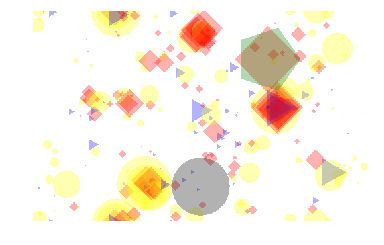

In [24]:
img = showSEvent(reduced, 105,show=True)

In [22]:
def transformEvent(f,ievent, show=True):
    img_collection = []
    for itype in [k for k in colors.keys()]:
        showEvent(f,ievent,itype,show)
        plt.savefig('fig.png', dpi=100,bbox_inches='tight', pad_inches=0)
        img = image = misc.imread('fig.png', mode='L') # 8-bit pixels, black and white
        img_collection.append(img)
    #print img.shape
    img_stack = np.stack(img_collection)
    #print img_stack.shape
    return img_stack

(5, 264, 421)
(264, 421)


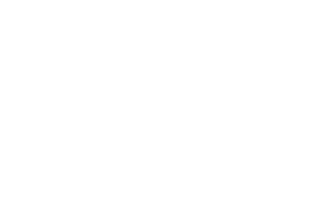

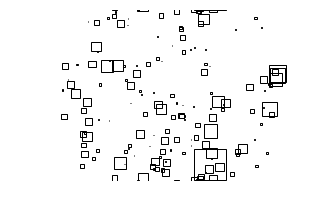

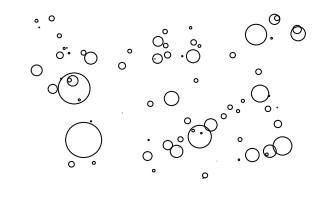

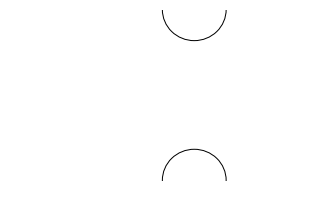

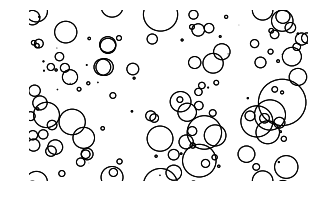

In [23]:
i = transformEvent(f,255,show=False)
print i.shape
print i[2].shape

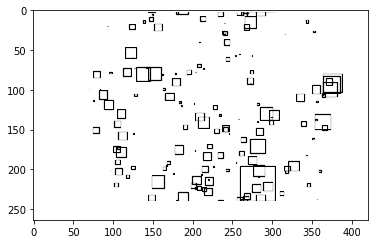

In [29]:
plt.imshow(i[1],interpolation='nearest', cmap="Greys_r")
plt.show()

In [25]:
def transformDataset(f, limit=None):
    s = f['Particles'].shape
    newDataset = None
    for ievent in range(s[0]):
        if limit and ievent>=limit:break
        i = transformEvent(f,ievent, show=False)
        if newDataset is None:
            newDataset = np.zeros((s[0] if not limit else limit ,)+i.shape) # #png format
        newDataset[ievent,...] = i
        if (ievent%100==0): print "%d/%d"%(ievent,s[0])
    return newDataset

0/7500


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


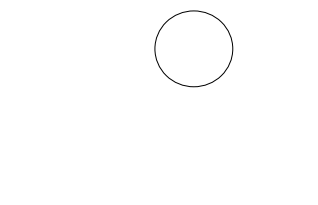

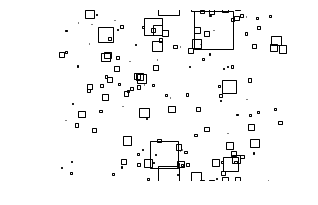

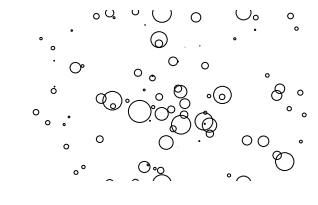

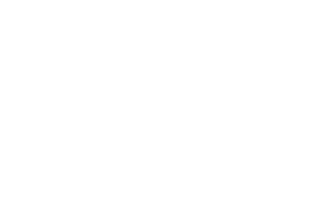

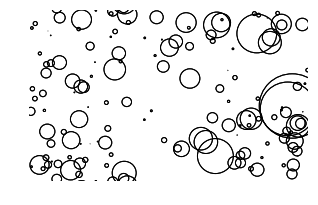

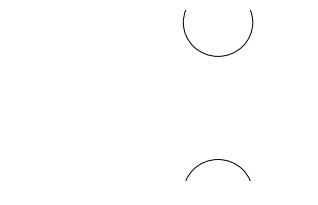

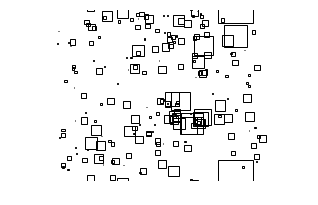

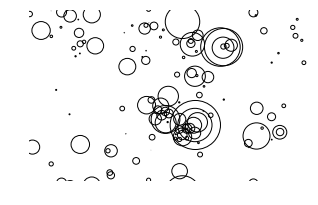

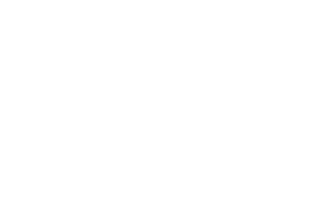

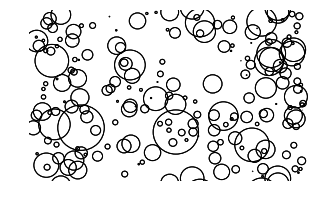

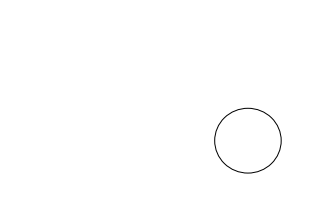

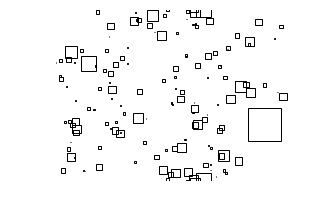

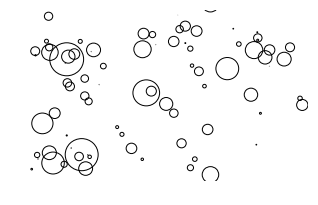

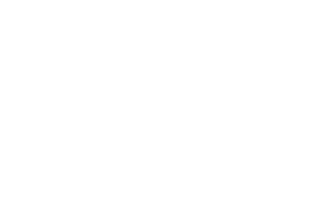

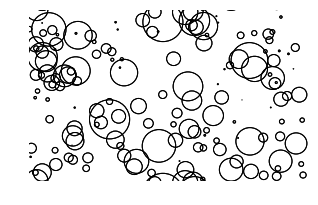

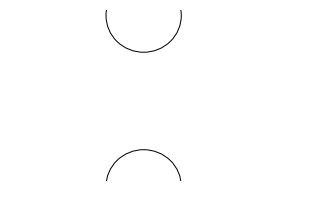

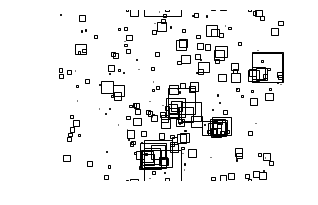

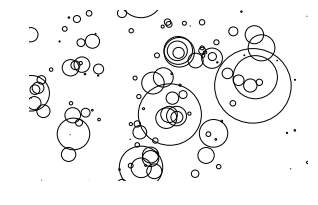

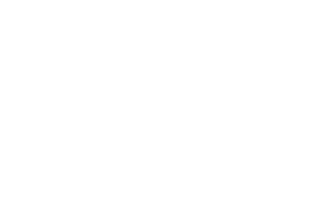

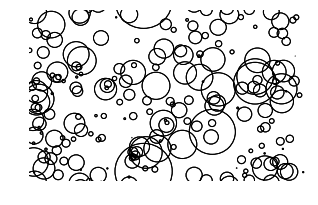

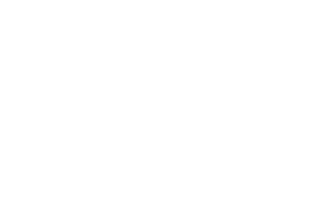

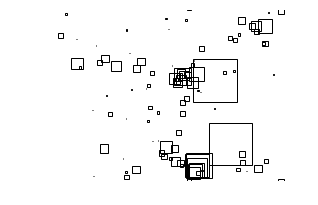

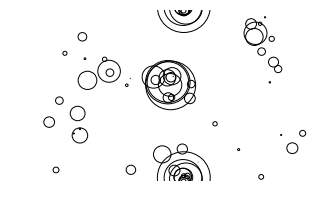

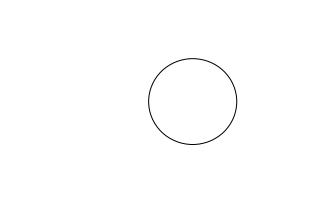

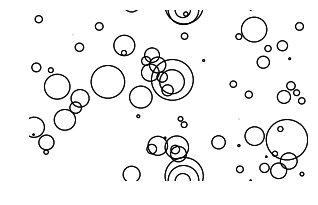

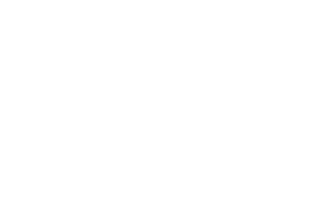

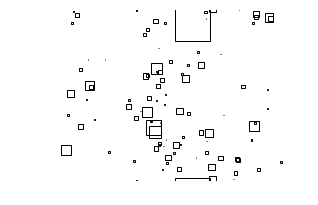

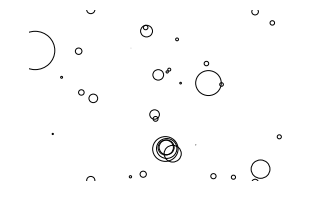

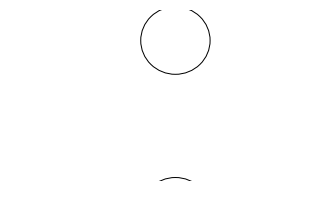

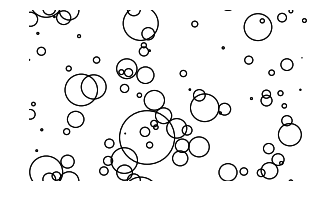

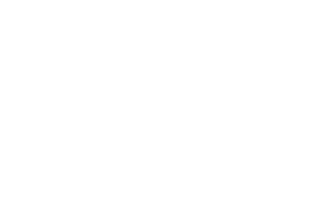

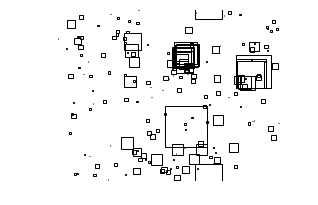

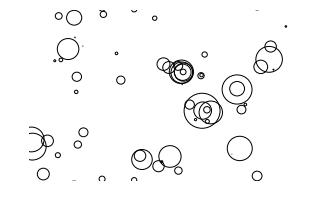

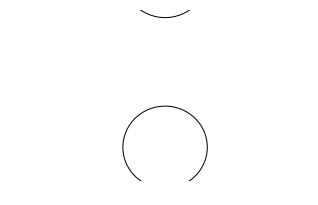

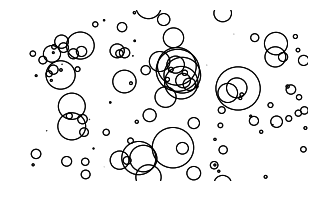

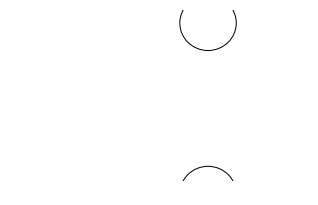

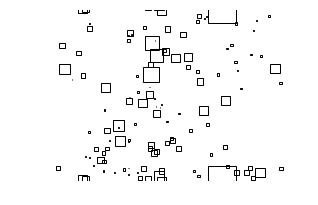

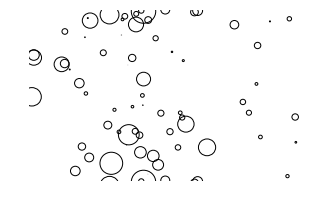

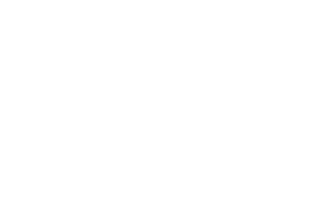

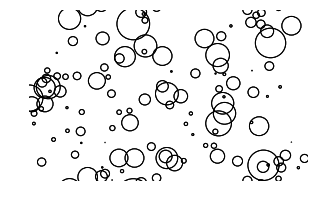

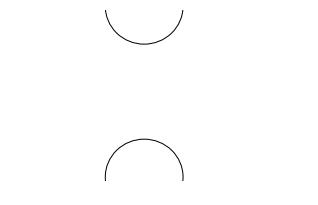

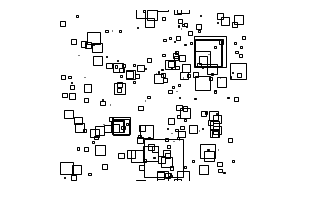

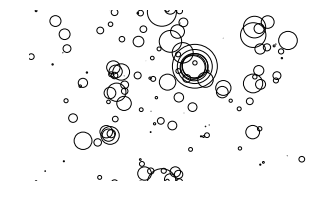

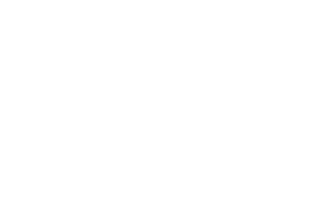

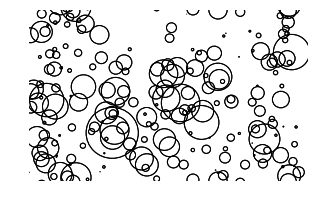

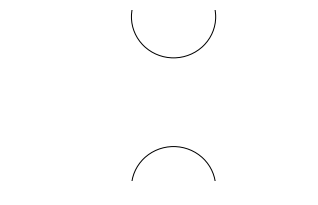

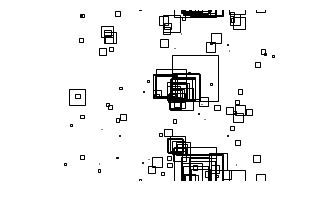

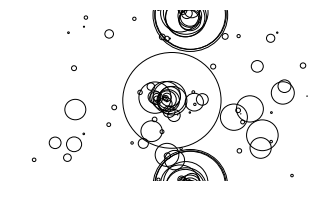

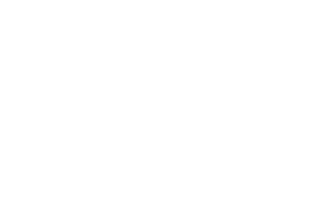

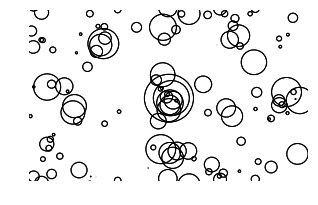

In [26]:
d = transformDataset(f, 10)

In [ ]:
def transformFile(fn, limit=None):
    
    ff = h5py.File(fn,'r')
    new_fn = fn.rsplit('/',1)[0]+'/images_stack/'+fn.rsplit('/',1)[-1]
    print "Converting",fn,"into",new_fn,("for %s events"%limit) if limit else ""
    nd = transformDataset(ff, limit)
    fo = h5py.File(new_fn,'w')
    fo['Labels'] = ff['Labels'][:limit,...] if limit else ff['Labels']
    fo['Images'] = nd/255. ## normalize it
    fo.close()

In [ ]:
for fn in fl:
    transformFile(fn)